## Train and Prediction on all data

Using rotated to hz + OpenCv border

Basic default transforms

see:

https://github.com/PPPW/deep-learning-random-explore/blob/master/CNN_archs/cnn_archs.ipynb

and

https://github.com/PPPW/deep-learning-random-explore/blob/master/CNN_archs/cnn_archs_more.ipynb

mem use 3GB with bs=32 TODO increase

using pretrained=False

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from torchvision.models import *
from efficientnet_pytorch import EfficientNet
import pretrainedmodels

In [3]:
from fastai.vision import *
from fastai.vision.models import *
from fastai.vision.learner import model_meta
import geopandas as gpd
from resizeimage import resizeimage
import datetime
import uuid
from os import listdir
from os.path import isfile, join

In [4]:
__version__

'1.0.59.dev0'

In [5]:
m = EfficientNet.from_pretrained('efficientnet-b0')

Loaded pretrained weights for efficientnet-b0


In [6]:
def arch_summary(arch):
    model = arch(False)
    tot = 0
    for i, l in enumerate(model.children()):
        n_layers = len(flatten_model(l))
        tot += n_layers
        print(f'({i}) {l.__class__.__name__:<12}: {n_layers:<4}layers (total: {tot})')

In [7]:
def get_groups(model, layer_groups):
    group_indices = [len(g) for g in layer_groups]
    curr_i = 0
    group = []
    for layer in model:
        group_indices[curr_i] -= len(flatten_model(layer))
        group.append(layer.__class__.__name__)
        if group_indices[curr_i] == 0:
            curr_i += 1
            print(f'Group {curr_i}:', group)   
            group = []

In [8]:
arch_summary(lambda _: m)

(0) Conv2dStaticSamePadding: 2   layers (total: 2)
(1) BatchNorm2d : 1   layers (total: 3)
(2) ModuleList  : 253 layers (total: 256)
(3) Conv2dStaticSamePadding: 2   layers (total: 258)
(4) BatchNorm2d : 1   layers (total: 259)
(5) AdaptiveAvgPool2d: 1   layers (total: 260)
(6) Dropout     : 1   layers (total: 261)
(7) Linear      : 1   layers (total: 262)
(8) MemoryEfficientSwish: 1   layers (total: 263)


In [9]:
arch_summary(lambda _: list(m.children())[2])

(0) MBConvBlock : 13  layers (total: 13)
(1) MBConvBlock : 16  layers (total: 29)
(2) MBConvBlock : 16  layers (total: 45)
(3) MBConvBlock : 16  layers (total: 61)
(4) MBConvBlock : 16  layers (total: 77)
(5) MBConvBlock : 16  layers (total: 93)
(6) MBConvBlock : 16  layers (total: 109)
(7) MBConvBlock : 16  layers (total: 125)
(8) MBConvBlock : 16  layers (total: 141)
(9) MBConvBlock : 16  layers (total: 157)
(10) MBConvBlock : 16  layers (total: 173)
(11) MBConvBlock : 16  layers (total: 189)
(12) MBConvBlock : 16  layers (total: 205)
(13) MBConvBlock : 16  layers (total: 221)
(14) MBConvBlock : 16  layers (total: 237)
(15) MBConvBlock : 16  layers (total: 253)


In [10]:
torch.cuda.set_device(0)
torch.cuda.current_device()

0

In [11]:
data_dir = Path('data')
colombia_rural = Path('data/stac/colombia/borde_rural')
colombia_soacha = Path('data/stac/colombia/borde_soacha')

In [12]:
guatemala_mixco1 = Path('data/stac/guatemala/mixco_1_and_ebenezer')
guatemala_mixco3 = Path('data/stac/guatemala/mixco_3')

In [13]:
st_lucia_castries = Path('data/stac/st_lucia/castries')
st_lucia_dennery = Path('data/stac/st_lucia/dennery')
st_lucia_gros_islet = Path('data/stac/st_lucia/gros_islet')

In [14]:
COUNTRY='colombia'
REGION='borde_rural'
DATASET = f'{COUNTRY}_{REGION}'
DATASET_PATH=colombia_rural
path=data_dir/f'{COUNTRY}_{REGION}/cropped/'
TRAIN_JSON = f'train-{REGION}.geojson'
TEST_JSON = f'test-{REGION}.geojson'

In [15]:
RETRAIN = True
RESIZE_IMAGES = True

In [16]:
MODEL_NAME='efficientnet'

In [17]:
NB_NUM='06_6'

In [18]:
DATE = datetime.datetime.today().strftime('%Y%m%d')
UID=str(uuid.uuid4())[:8]
print(f'UID: {UID}, DATE: {DATE}')                                                 

UID: 2de63e9e, DATE: 20191031


In [19]:
#DATE = '20191030'
#UID = '9c8c52b7'

In [20]:
SUB_NUM='6'

In [21]:
img_size=256
bs=64

In [22]:
train_images=data_dir/f'train/rotated/clipped/{img_size}'
test_images=data_dir/f'test/rotated/clipped/{img_size}'

In [23]:
test_names = get_image_files(test_images)

In [24]:
assert len(test_names)==7325

In [25]:
df_all=pd.read_csv(data_dir/'df_train_all.csv')

In [26]:
df_all.tail()

,id,roof_material,verified,country,region
22548,7a22ddec,healthy_metal,False,st_lucia,gros_islet
22549,7a2f73ea,healthy_metal,False,st_lucia,gros_islet
22550,7a34ffa4,healthy_metal,False,st_lucia,gros_islet
22551,7a41560a,healthy_metal,False,st_lucia,gros_islet
22552,7a283ad0,healthy_metal,False,st_lucia,gros_islet


In [27]:
df_test=pd.read_csv(data_dir/'df_test_all.csv')

In [28]:
df_test.tail()

,id,country,region
7320,7a4f3ff4,st_lucia,dennery
7321,7a4fc578,st_lucia,dennery
7322,7a4ac7b2,st_lucia,dennery
7323,7a47e25e,st_lucia,dennery
7324,7a4e3f78,st_lucia,dennery


In [29]:
assert len(df_test)==7325

In [30]:
df_all.loc[df_all['id'] == '7a204ec4']

,id,roof_material,verified,country,region
12960,7a204ec4,irregular_metal,True,guatemala,mixco_1_and_ebenezer


In [31]:
len(df_all)

22553

To put this in a `DataBunch` while using the [data block API](https://docs.fast.ai/data_block.html), we then need to using `ImageList` (and not `ImageDataBunch`). This will make sure the model created has the proper loss function to deal with the multiple classes.

In [32]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

### setup dataset

In [33]:
np.random.seed(42)
dep_var='roof_material'
src = (ImageList.from_df(path=train_images, df=df_all, cols='id', suffix='.tif')
       .split_by_rand_pct(0.2)
      .label_from_df(cols=dep_var)
      .add_test_folder(test_images))

In [34]:
data = (src.transform(tfms, size=img_size)
        .databunch(bs=bs).normalize(imagenet_stats))

In [35]:
#to check what params object has
#dir(data)

In [36]:
data.label_list

LabelLists;

Train: LabelList (18043 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data/train/rotated/clipped/256;

Valid: LabelList (4510 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
irregular_metal,healthy_metal,healthy_metal,irregular_metal,healthy_metal
Path: data/train/rotated/clipped/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data/train/rotated/clipped/256

In [37]:
data.loss_func

FlattenedLoss of CrossEntropyLoss()

`show_batch` still works, and show us the different labels separated by `;`.

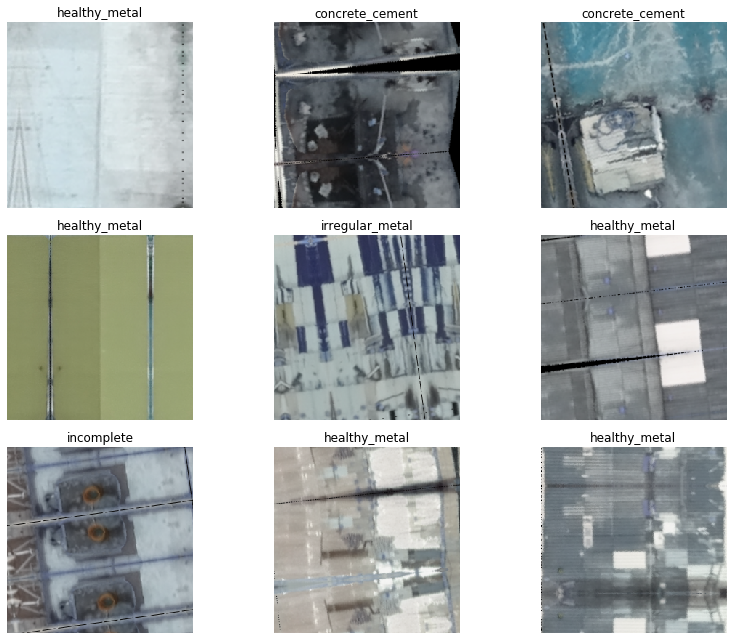

In [38]:
data.show_batch(rows=3, figsize=(12,9))

In [39]:
def get_groups(model, layer_groups):
    group_indices = [len(g) for g in layer_groups]
    curr_i = 0
    group = []
    for layer in model:
        group_indices[curr_i] -= len(flatten_model(layer))
        group.append(layer.__class__.__name__)
        if group_indices[curr_i] == 0:
            curr_i += 1
            print(f'Group {curr_i}:', group)   
            group = []

### Model

In [40]:
# "pretrained" is hardcoded to adapt to the PyTorch model function
def efficient_net_b0(pretrained=False):
    model = EfficientNet.from_pretrained('efficientnet-b0')
    return nn.Sequential(model)

In [41]:
model_meta[efficient_net_b0] =  { 'cut': noop, 
                               'split': lambda m: (list(m[0][0].children())[2][7], m[1]) }

In [42]:
list(efficient_net_b0()[0].children())

Loaded pretrained weights for efficientnet-b0


[Conv2dStaticSamePadding(
   3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
   (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
 ),
 BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True),
 ModuleList(
   (0): MBConvBlock(
     (_depthwise_conv): Conv2dStaticSamePadding(
       32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
       (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
     )
     (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
     (_se_reduce): Conv2dStaticSamePadding(
       32, 8, kernel_size=(1, 1), stride=(1, 1)
       (static_padding): Identity()
     )
     (_se_expand): Conv2dStaticSamePadding(
       8, 32, kernel_size=(1, 1), stride=(1, 1)
       (static_padding): Identity()
     )
     (_project_conv): Conv2dStaticSamePadding(
       32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False
       (static_padding): Identity

In [43]:
output_size = list(efficient_net_b0()[0].children())[-2].out_features

Loaded pretrained weights for efficientnet-b0


In [44]:
output_size

1000

In [45]:
custom_head = nn.Linear(output_size, data.c)

In [46]:
arch = efficient_net_b0
arch_name = 'efficient_net_b0'

In [47]:
learn = cnn_learner(data, arch, custom_head = custom_head, metrics=error_rate, bn_final=True).to_fp16()

Loaded pretrained weights for efficientnet-b0


In [48]:
get_groups(nn.Sequential(*list(learn.model[0][0].children())[:2], 
                         *list(learn.model[0][0].children())[2],
                         *list(learn.model[0][0].children())[3:],
                         learn.model[1]), 
           learn.layer_groups)

Group 1: ['Conv2dStaticSamePadding', 'BatchNorm2d', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock']
Group 2: ['MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'Conv2dStaticSamePadding', 'BatchNorm2d', 'AdaptiveAvgPool2d', 'Dropout', 'Linear', 'MemoryEfficientSwish']
Group 3: ['Linear']


In [49]:
#learn.model = torch.nn.DataParallel(learn.model, device_ids=[0, 1, 2])

We use the LR Finder to pick a good learning rate.

### train model

In [50]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


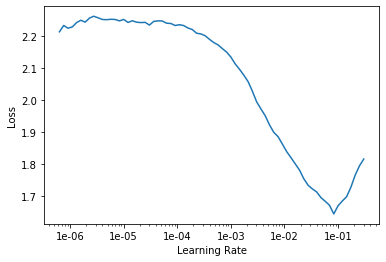

In [51]:
learn.recorder.plot()

Then we can fit the head of our network.

In [52]:
lr = 5e-3

In [53]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,0.757629,0.711452,0.258315,01:02
1,0.717446,0.707828,0.243237,01:01
2,0.650412,0.609036,0.212195,01:01
3,0.552436,0.557934,0.201996,01:01
4,0.525183,0.539951,0.197561,01:01


In [54]:
learn.save(f'stage-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

In [55]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,0.577024,0.630976,0.219512,01:01
1,0.624302,0.610163,0.202439,01:01
2,0.583970,0.568794,0.194678,01:02
3,0.501931,0.529270,0.184257,01:03
4,0.487797,0.516870,0.184922,01:03


In [56]:
learn.save(f'stage-1b-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

In [57]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,0.532553,0.556460,0.187361,01:04
1,0.571938,0.582318,0.190687,01:08
2,0.539911,0.566533,0.195787,01:13
3,0.486322,0.506910,0.176940,01:18
4,0.463540,0.489070,0.171397,01:25


In [58]:
learn.save(f'stage-1c-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

#### Load model

In [67]:
learn.load(f'stage-1c-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

Learner(data=ImageDataBunch;

Train: LabelList (18043 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data/train/rotated/clipped/256;

Valid: LabelList (4510 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
irregular_metal,healthy_metal,healthy_metal,irregular_metal,healthy_metal
Path: data/train/rotated/clipped/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data/train/rotated/clipped/256, model=Sequential(
  (0): Sequential(
    (0): EfficientNet(
      (_conv_stem): Conv2dStaticSamePadding(
        3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
        (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
      )
      (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, 

In [68]:
interp = ClassificationInterpretation.from_learner(learn)
interp.most_confused(min_val=2)

[('irregular_metal', 'healthy_metal', 263),
 ('healthy_metal', 'irregular_metal', 158),
 ('incomplete', 'irregular_metal', 66),
 ('other', 'healthy_metal', 43),
 ('concrete_cement', 'healthy_metal', 42),
 ('healthy_metal', 'concrete_cement', 26),
 ('irregular_metal', 'incomplete', 23),
 ('concrete_cement', 'irregular_metal', 22),
 ('incomplete', 'healthy_metal', 22),
 ('irregular_metal', 'concrete_cement', 22),
 ('incomplete', 'concrete_cement', 20),
 ('concrete_cement', 'incomplete', 12),
 ('other', 'irregular_metal', 9),
 ('healthy_metal', 'incomplete', 8),
 ('healthy_metal', 'other', 8),
 ('irregular_metal', 'other', 3),
 ('other', 'concrete_cement', 2)]

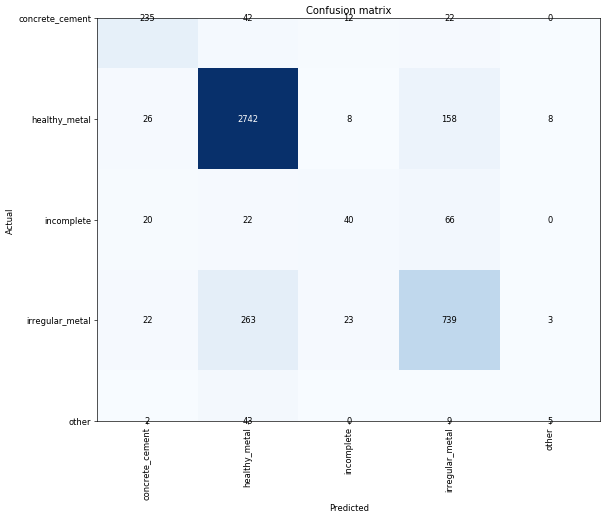

In [69]:
interp.plot_confusion_matrix(figsize=(10,10), dpi=60)

### Re-train

In [70]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


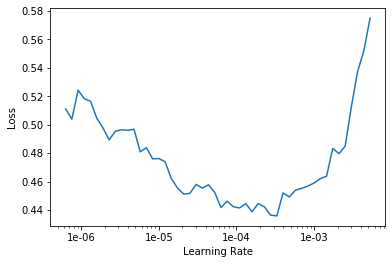

In [71]:
learn.lr_find()
learn.recorder.plot()

In [72]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,error_rate,time
0,0.459572,0.481284,0.166519,02:54
1,0.474854,0.474231,0.165188,02:56
2,0.399294,0.431105,0.151441,02:55
3,0.340181,0.411164,0.143459,02:56
4,0.334369,0.414619,0.142572,02:51


In [73]:
learn.save(f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

In [74]:
learn.load(f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

Learner(data=ImageDataBunch;

Train: LabelList (18043 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data/train/rotated/clipped/256;

Valid: LabelList (4510 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
irregular_metal,healthy_metal,healthy_metal,irregular_metal,healthy_metal
Path: data/train/rotated/clipped/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data/train/rotated/clipped/256, model=Sequential(
  (0): Sequential(
    (0): EfficientNet(
      (_conv_stem): Conv2dStaticSamePadding(
        3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
        (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
      )
      (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, 

In [75]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,error_rate,time
0,0.344961,0.429648,0.146341,02:55
1,0.346974,0.445613,0.153880,02:32
2,0.328156,0.431353,0.144568,02:21
3,0.290786,0.424080,0.139911,02:23
4,0.260693,0.424730,0.137916,02:24


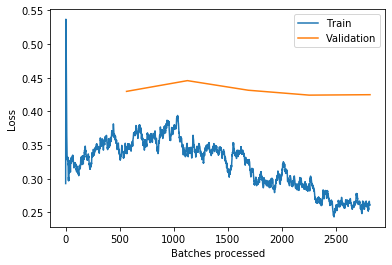

In [76]:
learn.recorder.plot_losses()

In [77]:
learn.save(f'stage-2b-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

In [38]:
learn.load(f'stage-2b-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

Learner(data=ImageDataBunch;

Train: LabelList (18043 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data/train/rotated/clipped/256;

Valid: LabelList (4510 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
irregular_metal,healthy_metal,healthy_metal,irregular_metal,healthy_metal
Path: data/train/rotated/clipped/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data/train/rotated/clipped/256, model=Sequential(
  (0): Sequential(
    (0): EfficientNet(
      (_conv_stem): Conv2dStaticSamePadding(
        3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
        (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
      )
      (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, 

In [59]:
learn = learn.to_fp32()

In [85]:
learn.export(f'stage-2b-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.pkl')

In [60]:
learn.export()

### 20191030 up to here, TOTO inference

### inference

In [61]:
#test_images=data_dir/f'test/rotated/clipped/{img_size}'
test_dataset=ImageList.from_folder(test_images)

In [62]:
len(test_dataset)

15325

In [63]:
learn = load_learner(path=data_dir/f'train/rotated/clipped/{img_size}', test=test_dataset)

In [64]:
#learn = load_learner(path=data_dir/f'train/rotated/clipped/{img_size}', file=f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.pkl', test=test_dataset)

In [65]:
learn.data.loss_func

FlattenedLoss of CrossEntropyLoss()

In [66]:
type(learn.data)

fastai.vision.data.ImageDataBunch

In [67]:
type(learn.dl(DatasetType.Test))

fastai.basic_data.DeviceDataLoader

In [68]:
len(learn.dl(DatasetType.Test))

240

Get number of items in the Valid dataset (in DeviceDataLoader)

In [69]:
#assert len(learn.dl(DatasetType.Test).dl)==7325

Required format:
    
<pre>
id	concrete_cement	healthy_metal	incomplete	irregular_metal	other
7a4d630a	0.9	0	0	0	0
7a4bbbd6	0.9	0	0	0	0
7a4ac744	0.9	0	0	0	0
7a4881fa	0.9	0	0	0	0
7a4aa4a8	0.9	0	0	0	0
</pre>


In [70]:
preds,y= learn.get_preds(ds_type=DatasetType.Test)

In [71]:
labels = np.argmax(preds, 1)

In [72]:
len(preds)

15325

In [73]:
preds[0].tolist()

[0.006203240714967251,
 0.9886038303375244,
 0.0001274336245842278,
 0.0038804360665380955,
 0.0011851179879158735]

In [74]:
preds_list=[]
for pred in preds:
    preds_list.append(pred.tolist())

In [75]:
len(labels)

15325

In [76]:
learn.data.classes

['concrete_cement', 'healthy_metal', 'incomplete', 'irregular_metal', 'other']

In [77]:
data.classes

['concrete_cement', 'healthy_metal', 'incomplete', 'irregular_metal', 'other']

In [78]:
test_predictions = [learn.data.classes[int(x)] for x in labels]

In [79]:
test_predictions[0]

'healthy_metal'

In [80]:
type(learn.data.test_ds)

fastai.data_block.LabelList

In [81]:
 learn.data.test_ds.x.items

array([PosixPath('data/test/rotated/clipped/256/7a4d9168.tif'),
       PosixPath('data/test/rotated/clipped/256/7a4ae922.tif'),
       PosixPath('data/test/rotated/clipped/256/7a48ca98.tif'),
       PosixPath('data/test/rotated/clipped/256/7a49c614.tif'), ...,
       PosixPath('data/test/rotated/clipped/256/sharp_t100/7a468774.tif'),
       PosixPath('data/test/rotated/clipped/256/sharp_t100/7a4b7946.tif'),
       PosixPath('data/test/rotated/clipped/256/sharp_t100/7a4e81f4.tif'),
       PosixPath('data/test/rotated/clipped/256/sharp_t100/7a501f50.tif')], dtype=object)

In [82]:
ids=[]
for item in learn.data.test_ds.x.items:
    base, id = os.path.split(item)
    id = id.split('.tif')[0]
    ids.append(id)

In [83]:
preds_list[0]

[0.006203240714967251,
 0.9886038303375244,
 0.0001274336245842278,
 0.0038804360665380955,
 0.0011851179879158735]

In [84]:
cols = learn.data.classes.copy()
cols.insert(0,'id')
df = pd.DataFrame(list(zip(ids, preds_list)), 
               columns =['id', 'pred']) 

In [85]:
cols

['id',
 'concrete_cement',
 'healthy_metal',
 'incomplete',
 'irregular_metal',
 'other']

In [86]:
df.head()

,id,pred
0,7a4d9168,"[0.006203240714967251, 0.9886038303375244, 0.0..."
1,7a4ae922,"[0.005177151877433062, 0.5271595120429993, 0.2..."
2,7a48ca98,"[0.0017985620070248842, 0.2945483922958374, 0...."
3,7a49c614,"[0.0002057464444078505, 0.6762409210205078, 0...."
4,7a4dd4f2,"[1.0094180652231444e-05, 0.9564899206161499, 1..."


In [87]:
pred_df = pd.DataFrame(df['pred'].values.tolist())

In [88]:
pred_df.insert(loc=0, column='id', value=ids)

In [89]:
pred_df.columns = cols

In [90]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other
0,7a4d9168,0.006203,0.988604,0.000127,0.003880,0.001185
1,7a4ae922,0.005177,0.527160,0.232923,0.234271,0.000470
2,7a48ca98,0.001799,0.294548,0.002052,0.701230,0.000370
3,7a49c614,0.000206,0.676241,0.000164,0.323107,0.000282
4,7a4dd4f2,0.000010,0.956490,0.000014,0.040904,0.002581


Required format:
    
<pre>
id	concrete_cement	healthy_metal	incomplete	irregular_metal	other
7a4d630a	0.9	0	0	0	0
7a4bbbd6	0.9	0	0	0	0
7a4ac744	0.9	0	0	0	0
7a4881fa	0.9	0	0	0	0
7a4aa4a8	0.9	0	0	0	0
</pre>


In [91]:
#pred_df = pd.read_csv(data_dir/f'submissions/stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.csv')

In [92]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other
0,7a4d9168,0.006203,0.988604,0.000127,0.003880,0.001185
1,7a4ae922,0.005177,0.527160,0.232923,0.234271,0.000470
2,7a48ca98,0.001799,0.294548,0.002052,0.701230,0.000370
3,7a49c614,0.000206,0.676241,0.000164,0.323107,0.000282
4,7a4dd4f2,0.000010,0.956490,0.000014,0.040904,0.002581


In [93]:
pred_ids=pred_df['id'].values.tolist()

In [94]:
df_baseline = pd.read_csv(data_dir/f'submissions/mean_baseline.csv')

In [95]:
df_baseline.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other
0,7a4d630a,0.093275,0.496369,0.044923,0.352455,0.012979
1,7a4bbbd6,0.093275,0.496369,0.044923,0.352455,0.012979
2,7a4ac744,0.093275,0.496369,0.044923,0.352455,0.012979
3,7a4881fa,0.093275,0.496369,0.044923,0.352455,0.012979
4,7a4aa4a8,0.093275,0.496369,0.044923,0.352455,0.012979


In [96]:
baseline_ids=df_baseline['id'].values.tolist()

In [97]:
baseline_ids

['7a4d630a',
 '7a4bbbd6',
 '7a4ac744',
 '7a4881fa',
 '7a4aa4a8',
 '7a514434',
 '7a485f72',
 '7a4b8d32',
 '7a47eb3c',
 '7a4be3ae',
 '7a46a330',
 '7a481620',
 '7a49c678',
 '7a4ea044',
 '7a47aa1e',
 '7a51aa1e',
 '7a498be0',
 '7a4a2848',
 '7a4c4cd6',
 '7a465038',
 '7a4e94aa',
 '7a49f62a',
 '7a45b6f0',
 '7a50bb90',
 '7a4d38e4',
 '7a48a3a6',
 '7a4ebe9e',
 '7a48352e',
 '7a4bfaec',
 '7a51e060',
 '7a4c0f5a',
 '7a4b9976',
 '7a4b27d4',
 '7a51c698',
 '7a474bb4',
 '7a480054',
 '7a4a4044',
 '7a4c35ca',
 '7a4d3fd8',
 '7a4c1a68',
 '7a4eb1c4',
 '7a4a51ce',
 '7a4a14fc',
 '7a5015d2',
 '7a4ba95c',
 '7a5101ae',
 '7a4d0a22',
 '7a5134ee',
 '7a4a85c2',
 '7a514b14',
 '7a4d0a90',
 '7a485fd6',
 '7a4f668c',
 '7a44e752',
 '7a5162d4',
 '7a465894',
 '7a4c9a10',
 '7a485810',
 '7a4a9788',
 '7a503198',
 '7a4e206a',
 '7a4c15ea',
 '7a4f8536',
 '7a513df4',
 '7a4d7624',
 '7a4c9e8e',
 '7a4b2554',
 '7a502b12',
 '7a4c32e6',
 '7a4a8a2c',
 '7a467b76',
 '7a51b554',
 '7a4622e8',
 '7a4a599e',
 '7a4d17c4',
 '7a4fb740',
 '7a4ceed4',

In [98]:
assert set(pred_ids)==set(baseline_ids)

#### sort by baseline ids

In [99]:
pred_df['id_cat'] = pd.Categorical(
    pred_df['id'], 
    categories=baseline_ids, 
    ordered=True
)

In [100]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other,id_cat
0,7a4d9168,0.006203,0.988604,0.000127,0.003880,0.001185,7a4d9168
1,7a4ae922,0.005177,0.527160,0.232923,0.234271,0.000470,7a4ae922
2,7a48ca98,0.001799,0.294548,0.002052,0.701230,0.000370,7a48ca98
3,7a49c614,0.000206,0.676241,0.000164,0.323107,0.000282,7a49c614
4,7a4dd4f2,0.000010,0.956490,0.000014,0.040904,0.002581,7a4dd4f2


In [101]:
pred_df=pred_df.sort_values('id_cat')

In [102]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other,id_cat
8041,7a4d630a,0.000046,0.998263,1.395496e-05,0.001609,6.832001e-05,7a4d630a
716,7a4d630a,0.000046,0.998263,1.395496e-05,0.001609,6.832001e-05,7a4d630a
764,7a4bbbd6,0.000013,0.999218,5.986710e-07,0.000768,9.997169e-09,7a4bbbd6
8089,7a4bbbd6,0.000013,0.999218,5.986710e-07,0.000768,9.997169e-09,7a4bbbd6
1841,7a4ac744,0.000502,0.983221,1.214056e-03,0.014996,6.751801e-05,7a4ac744


In [103]:
pred_df.drop(columns=['id_cat'],inplace=True)

In [104]:
pred_df=pred_df.drop_duplicates(subset=['id'])

In [105]:
pred_df.to_csv(data_dir/f'submissions/stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.csv', index=False)

In [1]:
### Submission 2: 0.4461


In [16]:

pred_df=pd.read_csv(data_dir/f'submissions/stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.csv')

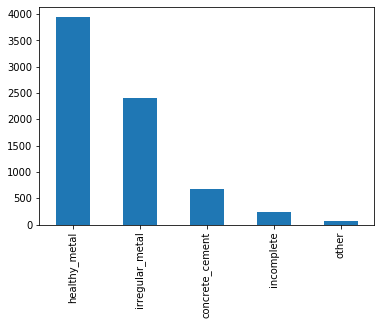

In [87]:
pred_df.drop(columns=['id'],inplace=True)
classes=pred_df.idxmax(axis=1)
pd.value_counts(classes).plot(kind="bar")